/home/chxing/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


,Accuracy,Recall,F1,AUC
Model,,,,
Logistic Regression,0.766758,0.673061,0.677298,0.834699
Random Forest,0.890507,0.828190,0.846187,0.939543
Voting Classifier,0.862299,0.818182,0.812086,0.927401
CNN1D,0.805278,0.746455,0.736020,0.876409
SelfAttentionNet,0.766758,0.793995,0.712308,0.848185
DCN,0.799211,0.760634,0.733709,0.868866
TabularMLP,0.791629,0.742285,0.721524,0.860043


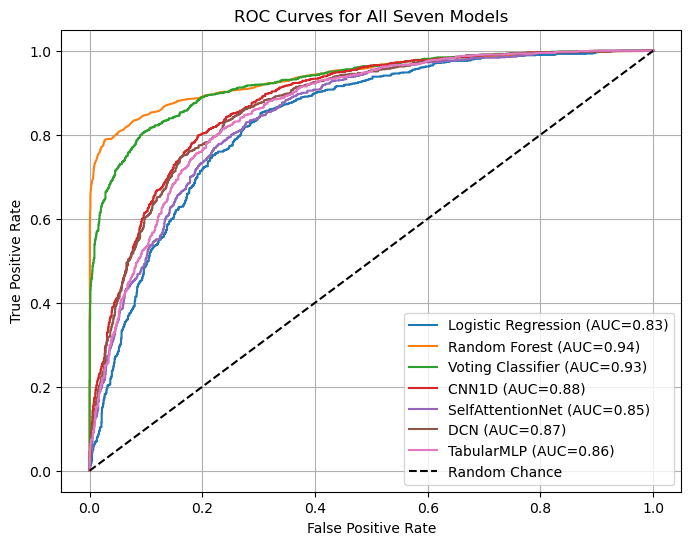

In [1]:
# === Full Notebook Code: Seven-Model Comparison Without External Imports ===

# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Jupyter-specific display
from IPython.display import display

# === Parameters ===
TRAIN_CSV    = 'train.csv'
TEST_CSV     = 'test.csv'
TOTAL_TRAIN  = 3000
RATIO_0_TO_1 = (2, 8)     # ratio of label=0 to label=1 in sampled training set
RANDOM_STATE = 42
BATCH_SIZE   = 32
LR           = 1e-3
EPOCHS_NN    = 30

# 2. Sampling function to create a balanced training set by specified ratio
def sample_df(df, total_n, ratio=(1,9), seed=None):
    r0, r1 = ratio
    n0 = int(total_n * r0 / (r0 + r1))
    n1 = total_n - n0
    df0 = df[df['label'] == 0].sample(n0, random_state=seed)
    df1 = df[df['label'] == 1].sample(n1, random_state=seed)
    return pd.concat([df0, df1]) \
             .sample(frac=1, random_state=seed) \
             .reset_index(drop=True)

# 3. Load and preprocess data
df_train = pd.read_csv(TRAIN_CSV)
#df_train      = sample_df(df_train_full, TOTAL_TRAIN, RATIO_0_TO_1, RANDOM_STATE)
df_test       = pd.read_csv(TEST_CSV)

# Identify feature columns (all except 'label')
features = [c for c in df_train.columns if c != 'label']

# Convert feature columns to numeric, fill NaN with 0
X_train_df = df_train[features].apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_df  = df_test [features].apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize features to zero mean and unit variance
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train_df).astype(np.float32)
X_test  = scaler.transform(X_test_df).astype(np.float32)

y_train = df_train['label'].values
y_test  = df_test ['label'].values

# Create DataLoader for neural network training and evaluation
train_ds     = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds      = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

# 4. Define models

## 4.1 Machine learning models (3 models)
ml_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Voting Classifier':   VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
        ],
        voting='soft'  # soft voting to enable probability outputs
    )
}

## 4.2 Neural network models (4 models)
# 4.2.1 1D-CNN model
class CNN1D(nn.Module):
    def __init__(self, feat_count):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(16)
        self.pool  = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(32)
        self.fc1   = nn.Linear((feat_count // 2) * 32, 64)
        self.fc2   = nn.Linear(64, 1)

    def forward(self, x):
        # x shape: (batch_size, feat_count)
        x = x.unsqueeze(1)                        # (batch_size, 1, feat_count)
        x = F.relu(self.bn1(self.conv1(x)))       # (batch_size, 16, feat_count)
        x = self.pool(x)                          # (batch_size, 16, feat_count/2)
        x = F.relu(self.bn2(self.conv2(x)))       # (batch_size, 32, feat_count/2)
        x = x.flatten(1)                          # (batch_size, 32 * (feat_count/2))
        x = F.relu(self.fc1(x))                   # (batch_size, 64)
        return self.fc2(x).squeeze(1)             # output logits (batch_size,)

# 4.2.2 Self-Attention Network model
class SelfAttentionNet(nn.Module):
    def __init__(self, feat_count, emb_dim=64, num_heads=4, num_layers=2, ff_dim=128, dropout=0.1):
        super().__init__()
        # Linear projection of each scalar feature to embedding dimension
        self.proj = nn.Linear(1, emb_dim)
        # Learnable positional embedding (feat_count x emb_dim)
        self.pos  = nn.Parameter(torch.zeros(feat_count, emb_dim))
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        # x shape: (batch_size, feat_count)
        B, F = x.size()
        x = x.unsqueeze(-1)                       # (batch_size, feat_count, 1)
        x = self.proj(x) + self.pos.unsqueeze(0)   # (batch_size, feat_count, emb_dim)
        x = x.permute(1, 0, 2)                     # (feat_count, batch_size, emb_dim)
        x = self.transformer(x)                    # (feat_count, batch_size, emb_dim)
        x = x.permute(1, 0, 2).mean(dim=1)          # (batch_size, emb_dim) via global pooling
        x = self.norm(x)                           # Layer normalization
        return self.head(x).squeeze(1)             # output logits (batch_size,)

# 4.2.3 Deep & Cross Network (DCN) model
class DCN(nn.Module):
    def __init__(self, dim, cross_layers=3, deep_dims=[128, 64], dropout=0.1):
        super().__init__()
        # Cross network layers (explicit feature crossing)
        self.cross = nn.ModuleList([nn.Linear(dim, 1) for _ in range(cross_layers)])
        # Deep network layers (standard feedforward)
        layers = []
        dims = [dim] + deep_dims
        for i in range(len(deep_dims)):
            layers += [
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.deep = nn.Sequential(*layers)
        # Final output layer
        self.out  = nn.Linear(dim + deep_dims[-1], 1)

    def forward(self, x):
        # x shape: (batch_size, dim)
        x0, xc = x, x
        # Cross network: each layer explicitly multiplies input with itself
        for layer in self.cross:
            xc = x0 * layer(xc) + xc
        # Deep network: standard MLP on original input
        xd = self.deep(x0)
        # Concatenate cross output and deep output, then final linear
        return self.out(torch.cat([xc, xd], dim=1)).squeeze(1)  # output logits

# 4.2.4 TabularMLP model (simple multilayer perceptron)
class TabularMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Two hidden layers with BatchNorm, ReLU, and Dropout
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()  # final activation to output probability
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        return self.net(x).squeeze(1)  # output probability (batch_size,)

# Instantiate the four neural network models
nn_models = {
    'CNN1D':            CNN1D(X_train.shape[1]),
    'SelfAttentionNet': SelfAttentionNet(X_train.shape[1]),
    'DCN':              DCN(X_train.shape[1]),
    'TabularMLP':       TabularMLP(X_train.shape[1])
}

# 5. Train machine learning models (Logistic Regression, Random Forest, Voting Classifier)
for name, model in ml_models.items():
    model.fit(X_train, y_train)

# 6. Train neural network models (CNN1D, SelfAttentionNet, DCN, TabularMLP)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for name, model in nn_models.items():
    model.to(device)
    # Choose loss depending on final activation
    if name == 'TabularMLP':
        criterion = nn.BCELoss()  # TabularMLP already applies Sigmoid
    else:
        criterion = nn.BCEWithLogitsLoss()  # other networks output logits

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS_NN):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).float()
            logits_or_probs = model(Xb)

            # Compute loss
            if name == 'TabularMLP':
                loss = criterion(logits_or_probs, yb)
            else:
                loss = criterion(logits_or_probs, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# 7. Evaluate all seven models and plot ROC curves
results = []
plt.figure(figsize=(8, 6))

# Combine dictionaries for easy iteration
all_models = {**ml_models, **nn_models}

for name, model in all_models.items():
    # Collect predicted probabilities and binary predictions
    if name in ml_models:
        probs = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)
    else:
        model.eval()
        probs_list, preds_list = [], []
        with torch.no_grad():
            for Xb, _ in test_loader:
                Xb = Xb.to(device)
                output = model(Xb)
                if name == 'TabularMLP':
                    p = output.cpu().numpy()                  # already a probability
                else:
                    p = torch.sigmoid(output).cpu().numpy()   # logits → probability
                probs_list.extend(p)
                preds_list.extend((p >= 0.5).astype(int))
        probs = np.array(probs_list)
        preds = np.array(preds_list)

    # Compute metrics: Accuracy, Recall, F1, AUC
    acc    = accuracy_score(y_test, preds)
    rec    = recall_score(y_test, preds)
    f1     = f1_score(y_test, preds)
    auc_sc = roc_auc_score(y_test, probs)
    results.append({'Model': name, 'Accuracy': acc, 'Recall': rec, 'F1': f1, 'AUC': auc_sc})

    # Collect ROC curve data
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_sc:.2f})')

# 8. Display results as a pandas DataFrame
df_results = pd.DataFrame(results).set_index('Model')
display(df_results)

# 9. Plot combined ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Seven Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()